In [74]:
# =====================
# Core Libraries
# =====================
import numpy as np
import pandas as pd

# =====================
# Visualization
# =====================
import seaborn as sns
import matplotlib.pyplot as plt

# =====================
# Preprocessing
# =====================
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, StandardScaler, PolynomialFeatures
from sklearn.impute import KNNImputer

# =====================
# Model Selection & Tuning
# =====================
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# =====================
# Regression Models
# =====================
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neural_network import MLPRegressor

# =====================
# Classification Models
# =====================
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# =====================
# Pipelines
# =====================
from sklearn.pipeline import Pipeline

# =====================
# Metrics
# =====================
from sklearn.metrics import (confusion_matrix, roc_curve, precision_recall_curve,
                             roc_auc_score, precision_score,
                             recall_score, f1_score)

# =====================
# Other Useful Tools
# =====================
from sklearn.datasets import make_regression
from numpy import log1p


In [38]:
data = pd.read_csv('train.csv')
data

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1,1
2186,2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3,1
2187,2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,1
2188,2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,18.0,1


In [39]:
data.drop(columns=['id'], inplace=True)


In [ ]:
data.isna().sum()

In [40]:
numerical_variables = ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'windspeed']
target_variable = 'rainfall' 
categorical_variables = ['winddirection']

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(numerical_variables):
    sns.boxplot(data=data, y=col, ax=axes[i], color='lightgreen')
    axes[i].set_title(f'{col} Boxplot')

Feature engineering functions:

In [47]:
def log_data(data):
    """Creat log of each numerical variable

    Args:
        data (data): Given Dataframe

    Returns:
        data: Dataframe with log feature
    """
    for col in numerical_variables:
        data[f"log_{col}"] = np.log1p(data[col])
    return data

In [44]:
def create_sunshine_cloud_features(X, sunshine_col='sunshine', cloud_col='cloud'):
    """
    Create new features from sunshine and cloud columns, including their log-transformed versions.
    
    Parameters:
    - X: Input DataFrame or numpy array
    - sunshine_col: Name or index of the sunshine column (default: 'sunshine')
    - cloud_col: Name or index of the cloud column (default: 'cloud')
    
    Returns:
    - X_new: DataFrame with original features, existing log features, and new features
    """
    # Convert to DataFrame if numpy array
    if isinstance(X, np.ndarray):
        X_df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
        if isinstance(sunshine_col, int) and isinstance(cloud_col, int):
            X_df.columns[sunshine_col] = 'sunshine'
            X_df.columns[cloud_col] = 'cloud'
        else:
            raise ValueError("For numpy array input, sunshine_col and cloud_col must be integers.")
    else:
        X_df = X.copy()
        if isinstance(sunshine_col, str) and isinstance(cloud_col, str):
            if sunshine_col not in X_df.columns or cloud_col not in X_df.columns:
                raise KeyError(f"Columns {sunshine_col} or {cloud_col} not found in DataFrame.")
        else:
            raise ValueError("For DataFrame input, sunshine_col and cloud_col must be column names.")

    # Create log-transformed features (handle zeros/negatives)
    X_df['log_sunshine'] = np.log1p(X_df['sunshine'] - X_df['sunshine'].min() + 1)
    X_df['log_cloud'] = np.log1p(X_df['cloud'] - X_df['cloud'].min() + 1)

    # Create new features
    X_df['sunshine_x_cloud'] = X_df['sunshine'] * X_df['cloud']
    X_df['log_sunshine_x_log_cloud'] = X_df['log_sunshine'] * X_df['log_cloud']
    X_df['log_sunshine_x_cloud'] = X_df['log_sunshine'] * X_df['cloud']
    X_df['sunshine_x_log_cloud'] = X_df['sunshine'] * X_df['log_cloud']
    X_df['sunshine_div_cloud'] = X_df['sunshine'] / (X_df['cloud'] + 1e-6)
    X_df['log_sunshine_div_log_cloud'] = X_df['log_sunshine'] / (X_df['log_cloud'] + 1e-6)
    X_df['sunshine_minus_cloud'] = X_df['sunshine'] - X_df['cloud']
    X_df['log_sunshine_minus_log_cloud'] = X_df['log_sunshine'] - X_df['log_cloud']
    X_df['log_sunshine_sq'] = X_df['log_sunshine']**2
    X_df['log_cloud_sq'] = X_df['log_cloud']**2
    
    return X_df

In [48]:
data = log_data(data)

In [49]:
data = create_sunshine_cloud_features(data)

In [50]:
data

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,...,sunshine_x_cloud,log_sunshine_x_log_cloud,log_sunshine_x_cloud,sunshine_x_log_cloud,sunshine_div_cloud,log_sunshine_div_log_cloud,sunshine_minus_cloud,log_sunshine_minus_log_cloud,log_sunshine_sq,log_cloud_sq
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,...,96.8,5.065668,99.563386,4.925070,0.012500,0.252695,-86.9,-3.345935,1.280071,20.046545
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,...,0.0,3.126690,63.076393,0.000000,0.000000,0.153662,-91.0,-3.817712,0.480453,20.347853
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,...,390.1,8.979098,109.610763,31.956225,0.176596,0.605728,-38.7,-1.518004,5.438895,14.823637
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,...,0.0,3.156507,65.848982,0.000000,0.000000,0.152210,-95.0,-3.860730,0.480453,20.737795
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,...,162.0,6.557991,77.524497,13.703985,0.080000,0.452566,-41.4,-2.083896,2.967925,14.490679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,...,8.8,3.321903,65.290486,0.447734,0.001136,0.165709,-87.9,-3.735399,0.550471,20.046545
2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,...,0.0,3.103453,60.996952,0.000000,0.000000,0.154812,-88.0,-3.784190,0.480453,20.046545
2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,...,395.0,8.502553,153.726902,21.847239,0.063291,0.445345,-74.0,-2.423538,3.786566,19.092075
2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,...,9.3,3.362905,69.000173,0.453260,0.001075,0.163689,-92.9,-3.790662,0.550471,20.544458


In [ ]:
train = data.drop(target_variable,axis=1)
test = data[target_variable]
x_train,x_test,y_train,y_test = train_test_split(train,test,random_state=42,test_size=.2)

In [52]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)

In [53]:
param_grid = {
    'hidden_layer_sizes': [(64, 32), (128, 64), (64, 64, 32)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

grid = GridSearchCV(MLPRegressor(max_iter=500), param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

print("Best parameters:", grid.best_params_)
print("Best score:", -grid.best_score_)

Best parameters: {'alpha': 0.001, 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.01}
Best score: -0.4224969044909532


In [54]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': np.arange(50, 301, 50),
    'max_depth': [None] + list(np.arange(5, 31, 5)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],  # no 'auto'
    'bootstrap': [True, False]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,                 # Number of parameter settings sampled
    scoring='roc_auc',         # Optimize for ROC AUC
    cv=5,                     # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1                 # Use all CPU cores
)

# Run hyperparameter search
random_search.fit(x_train, y_train)

# Best parameters
print("Best Hyperparameters:", random_search.best_params_)

# Evaluate on test set
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(x_test)
y_proba = best_rf.predict_proba(x_test)[:, 1]

print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'n_estimators': np.int64(100), 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': np.int64(5), 'bootstrap': True}
              precision    recall  f1-score   support

           0       0.79      0.61      0.69       119
           1       0.86      0.94      0.90       319

    accuracy                           0.85       438
   macro avg       0.83      0.77      0.79       438
weighted avg       0.84      0.85      0.84       438



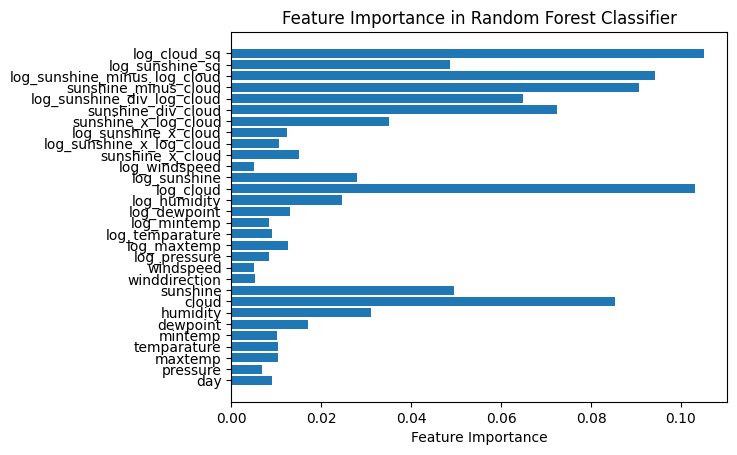

In [55]:
feature_importances = best_rf.feature_importances_

plt.barh(x_train.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()

In [ ]:
param_grid = {
    'penalty': ['l1', 'l2'],  
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'], 
    'max_iter': [100, 200, 500]
}
logreg = LogisticRegression(random_state=42)

grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',  
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

In [62]:
# Create a pipeline with scaling, polynomial features, and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('model', LogisticRegression())
])

# Define parameter grid for GridSearchCV
param_grid = {
    'poly__degree': [1, 2, 3],  # Polynomial degrees
    'poly__interaction_only': [False, True],
    'model__C': [0.01, 0.1, 1, 10],  # Inverse of regularization strength
    'model__penalty': ['l2'],        # Use 'l2' for solvers like lbfgs or saga
    'model__solver': ['lbfgs', 'saga'],  # Compatible solvers
}

# Perform GridSearchCV with MSE as the scoring metric
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  
    n_jobs=-1
)

# Fit the model
grid_search.fit(x_train, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_mse = -grid_search.best_score_  # Convert negative MSE to positive

# Evaluate on test set
y_pred = best_model.predict(x_test)
test_mse = mean_squared_error(y_test, y_pred)

# Print results
print("Best Hyperparameters:", best_params)
print(f"Best Cross-Validation MSE: {best_mse:.4f}")
print(f"Test Set MSE: {test_mse:.4f}")

# Example predictions
print("\nSample Predictions (first 5):")
print("Actual:", y_test[:5])
print("Predicted:", y_pred[:5])

Best Hyperparameters: {'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'lbfgs', 'poly__degree': 1, 'poly__interaction_only': False}
Best Cross-Validation MSE: -0.8727
Test Set MSE: 0.1438

Sample Predictions (first 5):
Actual: 289     1
1692    1
1590    1
383     1
1818    1
Name: rainfall, dtype: int64
Predicted: [1 1 1 1 1]


d:\projects\kaggle-datasets\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Create pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('model', SVC())
])

# Define hyperparameter grid
param_grid = {
    'poly__degree': [1, 2],
    'poly__interaction_only': [False, True],
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf'],  
    'model__gamma': ['scale', 'auto']
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

# Evaluation
y_pred = grid_search.predict(x_test)

print("Best Parameters:", grid_search.best_params_)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'rbf', 'poly__degree': 1, 'poly__interaction_only': False}
Test Accuracy: 0.8493150684931506
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.61      0.69       119
           1       0.87      0.94      0.90       319

    accuracy                           0.85       438
   macro avg       0.83      0.78      0.79       438
weighted avg       0.84      0.85      0.84       438



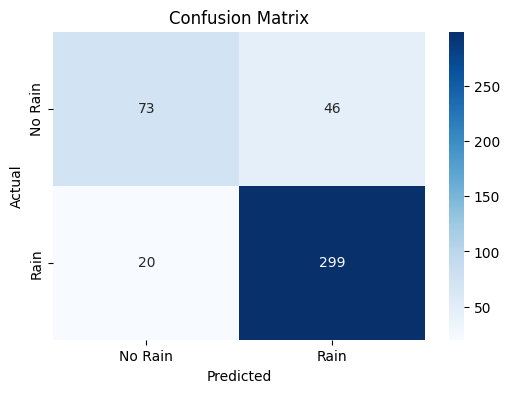

In [75]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test R²:", r2_score(y_test, y_pred))

Predict Test.csv.

In [95]:
test_data = pd.read_csv('test.csv')
test_final = test_data.drop(columns=['id'])

In [96]:
test_final = log_data(test_final)

In [97]:
test_final = create_sunshine_cloud_features(test_final)

In [99]:
from sklearn.impute import SimpleImputer


imputer = SimpleImputer(strategy='mean')
test_final_imputed = imputer.fit_transform(test_final)


In [100]:
test_final_imputed

array([[ 1.00000000e+00,  1.01950000e+03,  1.75000000e+01, ...,
        -3.92197334e+00,  4.80453014e-01,  2.12993374e+01],
       [ 2.00000000e+00,  1.01650000e+03,  1.75000000e+01, ...,
        -3.92197334e+00,  4.80453014e-01,  2.12993374e+01],
       [ 3.00000000e+00,  1.02390000e+03,  1.12000000e+01, ...,
        -3.89182030e+00,  4.80453014e-01,  2.10219268e+01],
       ...,
       [ 3.63000000e+02,  1.02270000e+03,  2.10000000e+01, ...,
        -3.89182030e+00,  4.80453014e-01,  2.10219268e+01],
       [ 3.64000000e+02,  1.01440000e+03,  2.10000000e+01, ...,
        -3.86072971e+00,  4.80453014e-01,  2.07377947e+01],
       [ 3.65000000e+02,  1.02090000e+03,  2.22000000e+01, ...,
        -3.72240215e+00,  6.21665009e-01,  2.03478535e+01]],
      shape=(730, 30))

In [101]:
y_pred = grid_search.predict(test_final_imputed)
submission = pd.DataFrame({'id': test_data['id'], 'rainfall': y_pred})
submission.to_csv('submission.csv', index=False)

d:\projects\kaggle-datasets\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
